In [2]:
import sys,os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.chdir('drive/MyDrive/Notebook Machine Learning/Projet/')

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: advanced model outside the course (XGBoost)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

# Display options
pd.set_option("display.max_columns", 100)


# Load dataset
data_path = "2015-building-energy-benchmarking.csv"
df_initial = pd.read_csv(data_path)

print("Shape of raw dataset:", df_initial.shape)
df_initial.head()

Shape of raw dataset: (3340, 47)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


# 1 : Exploratory Data Analysis

In [5]:
df=df_initial.copy()

In [6]:
df.shape

(3340, 47)

Columns:
 ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Seattle Police Department Micr

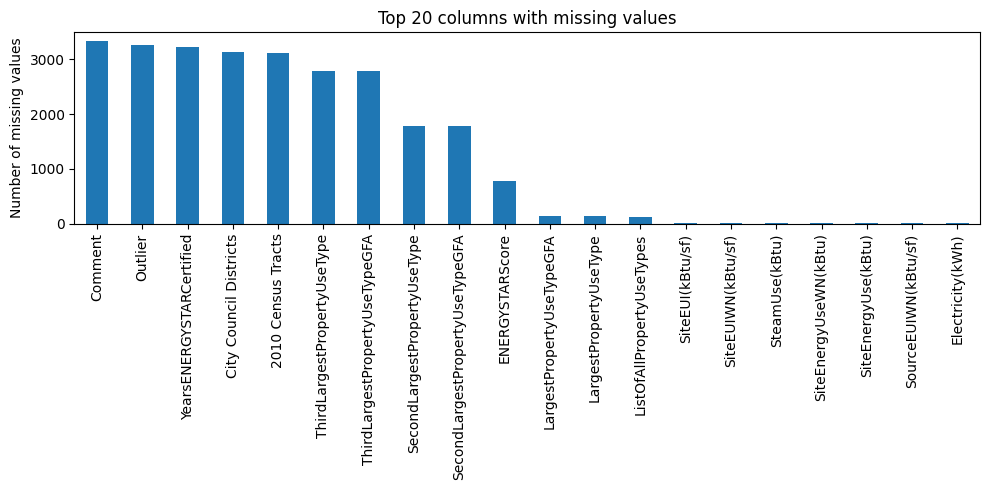

,count,mean,std,min,25%,50%,75%,max
OSEBuildingID,3340.0,2.052217e+04,1.151152e+04,1.0,19921.75,22977.0,25748.000,50059.0
DataYear,3340.0,2.015000e+03,0.000000e+00,2015.0,2015.00,2015.0,2015.000,2015.0
CouncilDistrictCode,3340.0,4.450898e+00,2.127203e+00,1.0,3.00,4.0,7.000,7.0
YearBuilt,3340.0,1.967625e+03,3.294985e+01,1900.0,1947.00,1973.0,1996.000,2015.0
NumberofBuildings,3340.0,1.035629e+00,7.844628e-01,1.0,1.00,1.0,1.000,39.0
NumberofFloors,3332.0,4.682173e+00,5.458460e+00,0.0,2.00,4.0,5.000,99.0
PropertyGFATotal,3340.0,9.077289e+04,1.493058e+05,20000.0,28487.00,43855.0,88428.000,2200000.0
PropertyGFAParking,3340.0,1.105403e+04,3.529633e+04,-3.0,0.00,0.0,4304.250,512608.0
PropertyGFABuilding(s),3340.0,7.971886e+04,1.292314e+05,-50550.0,26683.00,41326.0,78726.000,2200000.0
LargestPropertyUseTypeGFA,3204.0,7.488154e+04,1.236249e+05,5872.0,25000.00,39000.0,72067.500,1719643.0


In [7]:
#Missing values

print("Columns:\n", df.columns.tolist())
print("\nBasic info:")
df.info()

print("\nMissing values per column:")
missing_counts = df.isna().sum().sort_values(ascending=False)
print(missing_counts)

# Visualize missing values (top 20 columns with most missing)
plt.figure(figsize=(10,5))
missing_counts.head(20).plot(kind="bar")
plt.title("Top 20 columns with missing values")
plt.ylabel("Number of missing values")
plt.tight_layout()
plt.show()

# Basic statistics for numeric columns
df.describe().T.head(20)

In [8]:
target_col="SiteEnergyUse(kBtu)"

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Number of numeric columns:", len(numeric_cols))
print("Number of categorical columns:", len(categorical_cols))

Number of numeric columns: 32
Number of categorical columns: 15


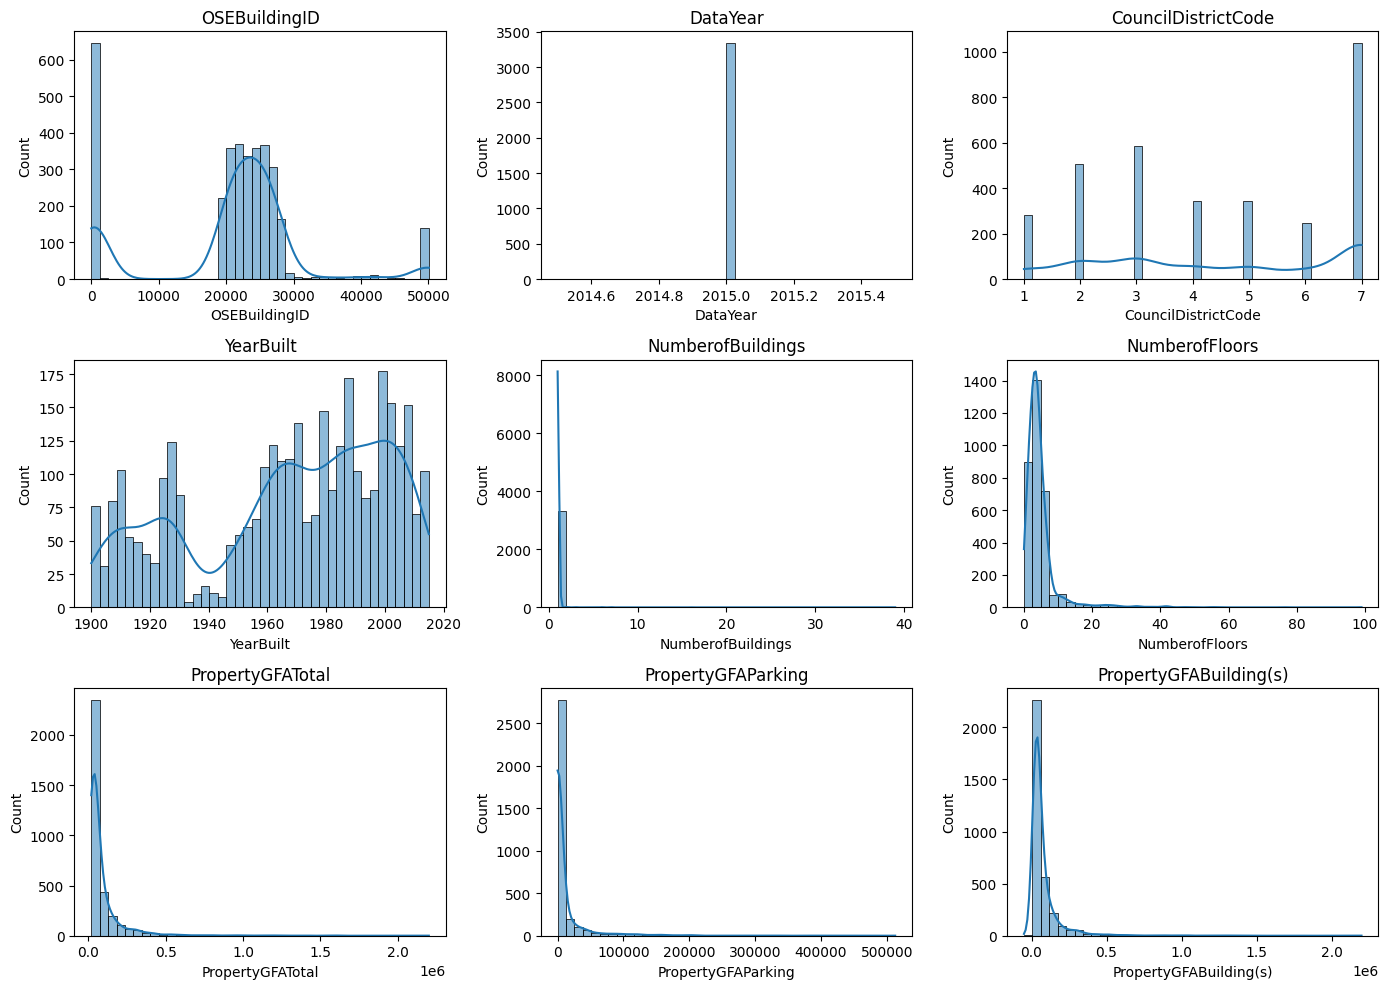

In [10]:
#1 Histograms of numeric variables

numeric_sample = df[numeric_cols].sample(min(5000, len(df)), random_state=42)

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.histplot(numeric_sample[col], bins=40, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

The numerical variables in the dataset are almost all highly right-skewed, with long tails and several extreme outliers. Surface-related features such as PropertyGFATotal, PropertyGFABuilding(s) and LargestPropertyUseTypeGFA show particularly heavy-tailed distributions, meaning that a small number of very large buildings dominate the upper range.


This justifies applying preprocessing steps such as median imputation, scaling, and potentially removing the top 1% outliers of the target variable.


YearBuilt show multimodal patterns that suggest non-linear relationships with energy use; therefore, we will use non-linear models like Random Forest or Gradient Boosting to outperform linear regression.


DataYear is the same for every building so we will remove it.

NumberOfBuildings, NumberOfFloors include rare extreme values that need attention but remain relevant.

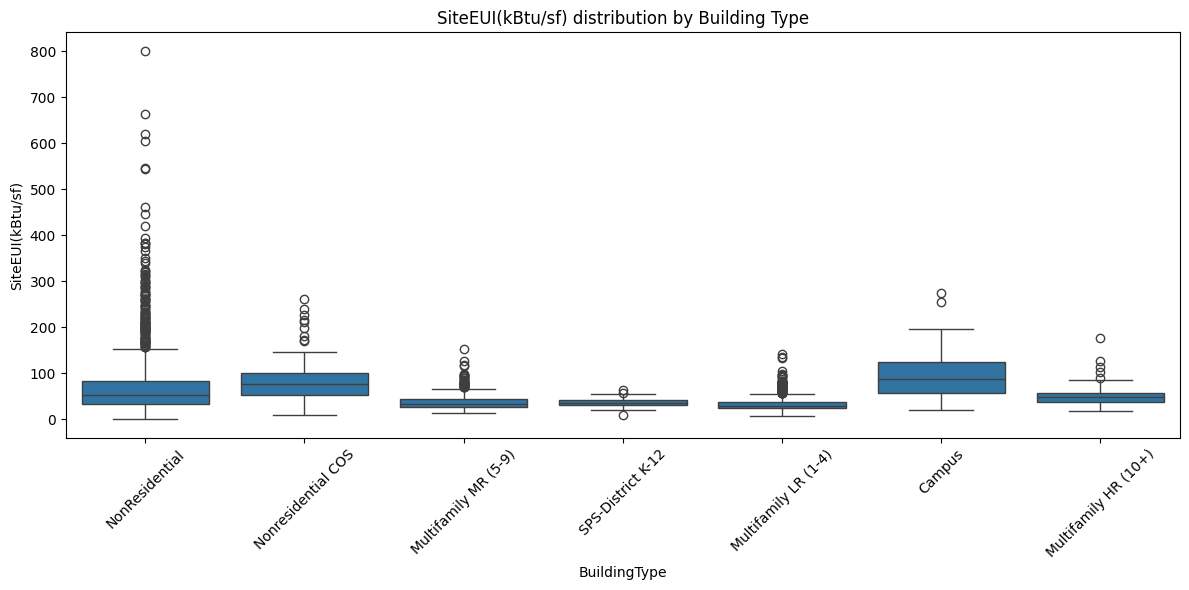

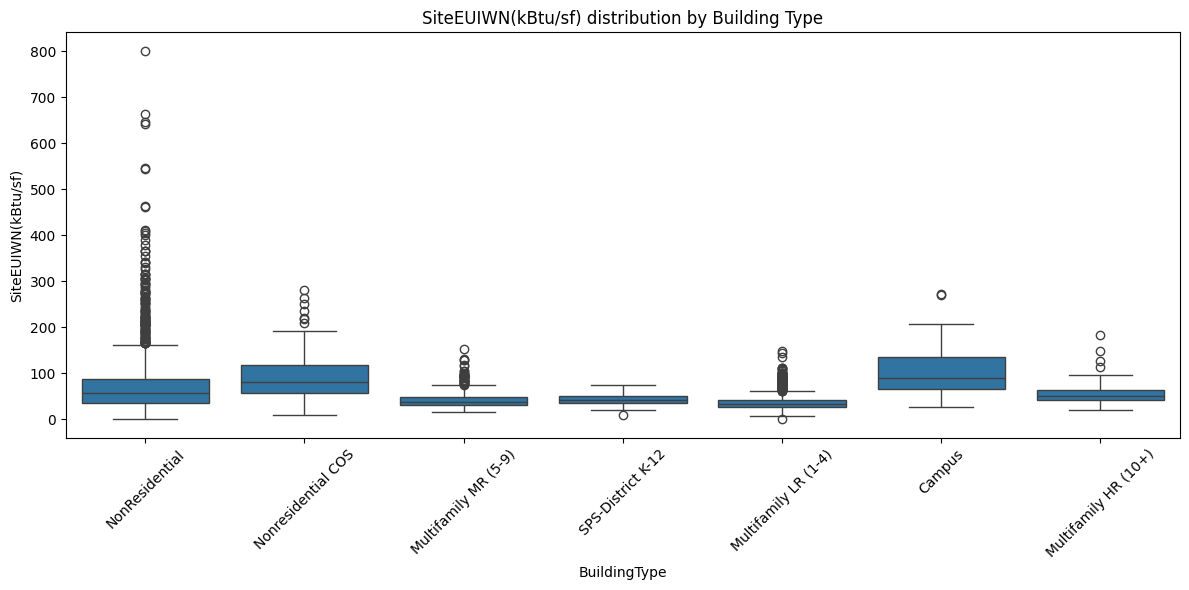

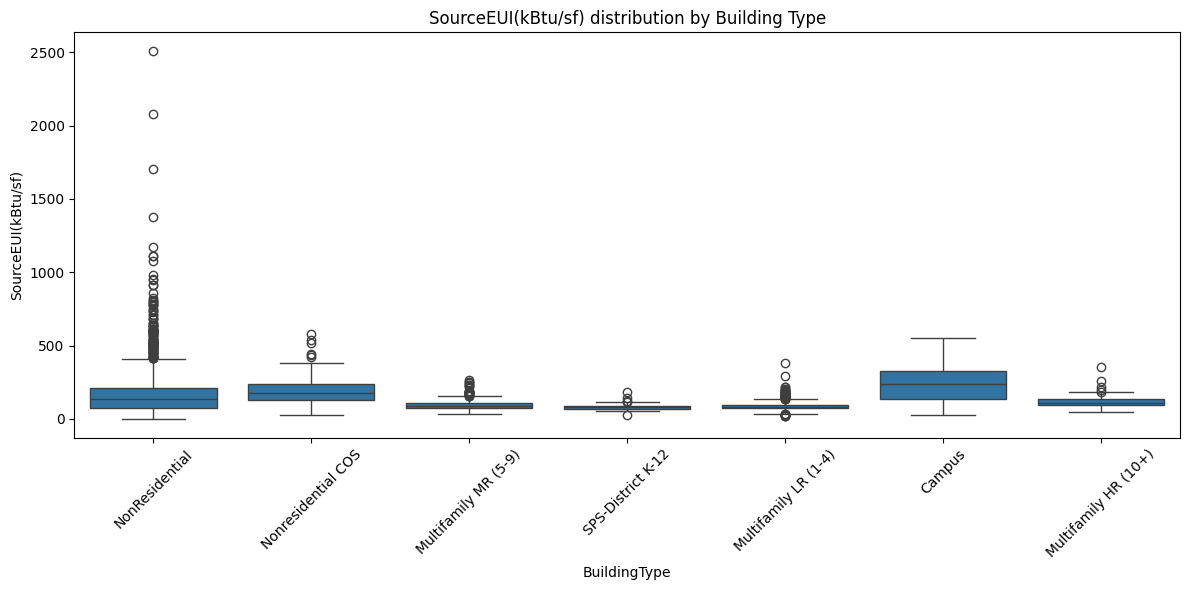

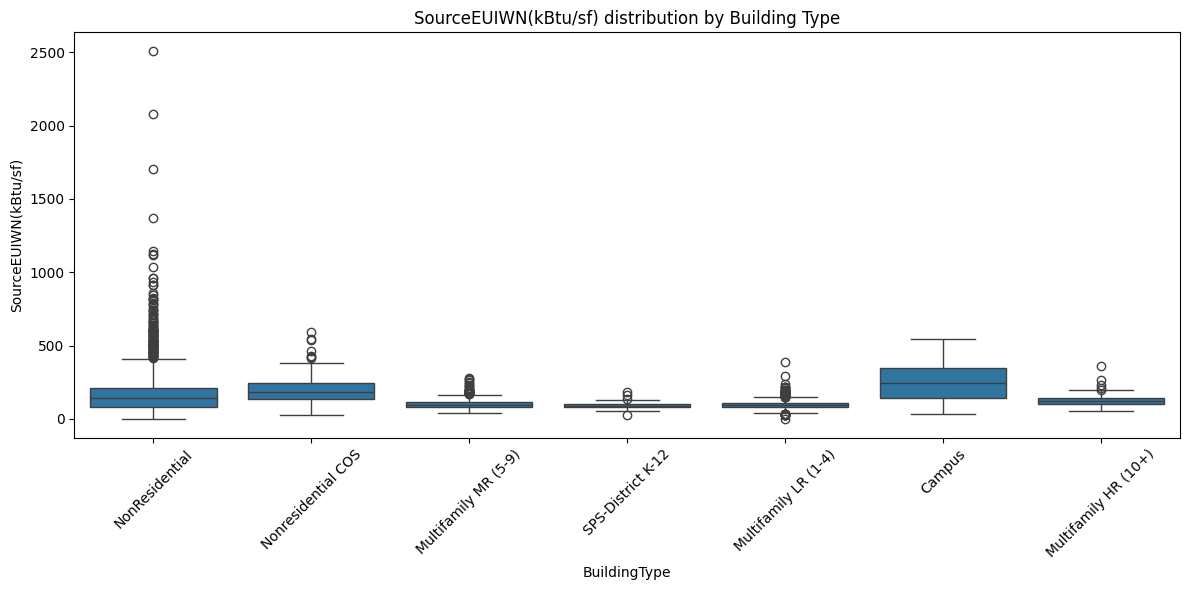

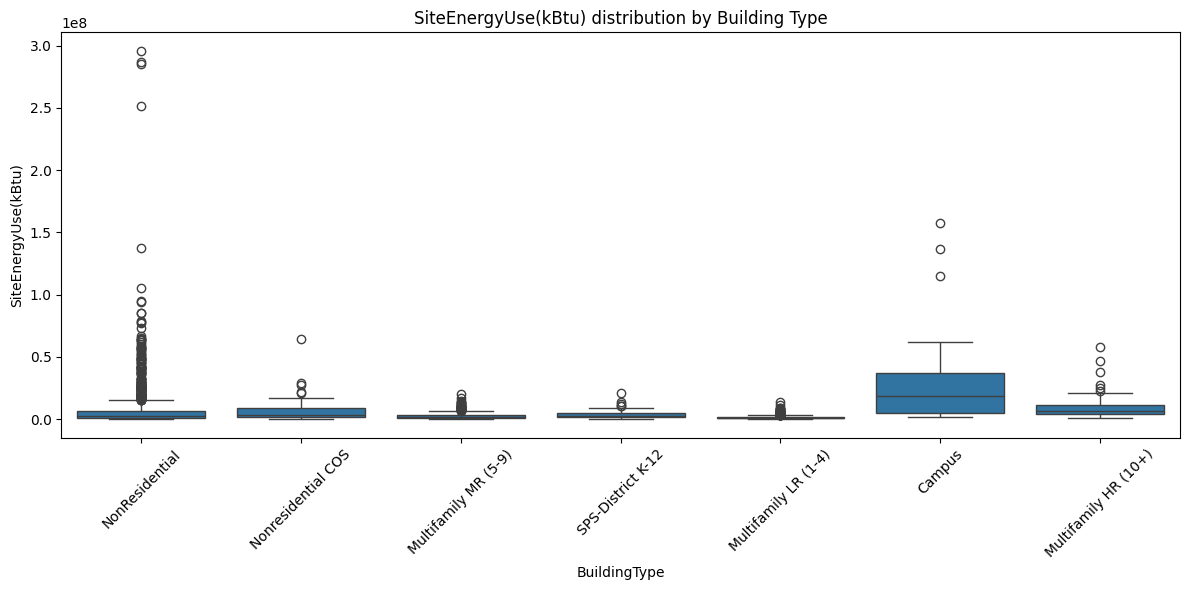

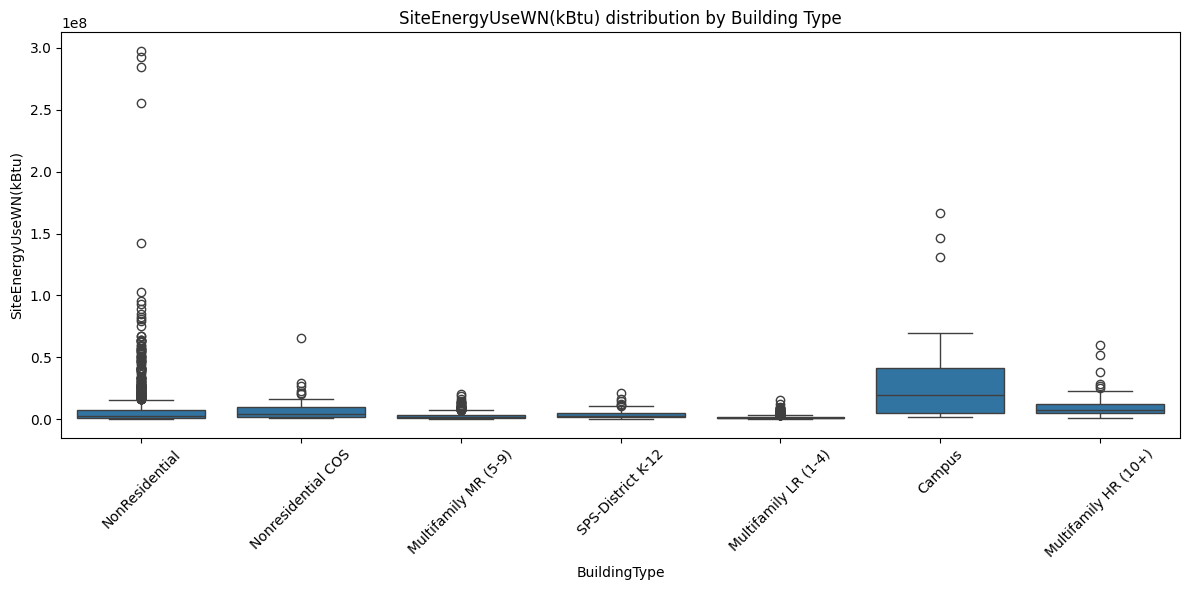

In [11]:
#2 Boxplots: energy by building type

energy_cols = [c for c in df.columns if "EUI" in c or "Energy" in c]

for col in energy_cols:
    if df[col].dtype != object:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x="BuildingType", y=col)
        plt.xticks(rotation=45)
        plt.title(f"{col} distribution by Building Type")
        plt.tight_layout()
        plt.show()

**Observations**

Energy consumption is strongly dependent on building type.

Campus and Nonresidential buildings show the highest energy use values—both in intensity (EUI) and in total consumption—with extremely wide variability and many outliers.

In contrast, all Multifamily categories are much more homogeneous and consistently show lower energy use. This confirms that building function is one of the most important predictors in the dataset.

Additionally, weather normalization has little impact on the distributions, indicating that intrinsic building characteristics dominate over climate effects.

 Finally, the presence of extreme outliers—especially in Campus and Nonresidential groups—justifies applying an upper percentile cutoff (e.g. top 1%) to stabilize model training

**Consequences**

- Keep BuildingType, very useful
- Remove the top 1% of the target variable
- log-transform of EUI
- One-hot encoding for BuildinType
- Remove the weather normalized versions (WN), which are not useful. So we keep only SiteEUI(kBtu/sf), SourceEUI(kBtu/sf) and SiteEnergyUse(kBtu)

,mean,median,count
BuildingType,,,
Multifamily LR (1-4),1.364255e+06,962526.5,1026
Multifamily MR (5-9),2.777289e+06,1980277.5,554
SPS-District K-12,3.573923e+06,2196843.0,93
Nonresidential COS,7.015079e+06,3395428.0,68
NonResidential,7.579018e+06,2446098.0,1460
Multifamily HR (10+),9.475857e+06,6750112.0,107
Campus,3.485076e+07,18899064.5,22


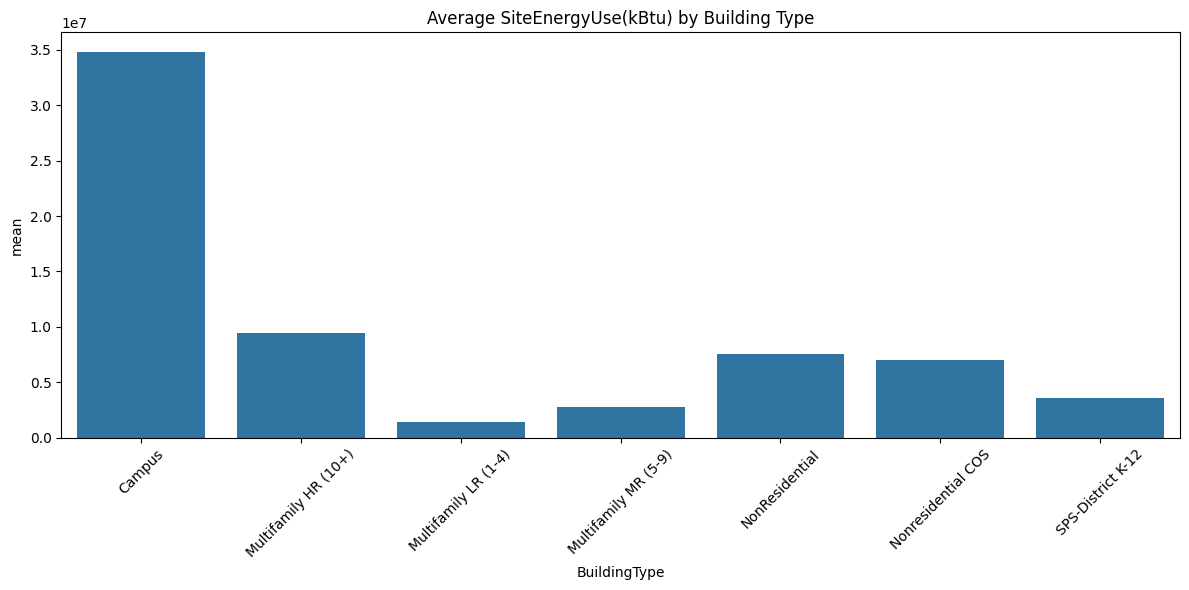

In [12]:
#3 Focus on SiteEnergyUse by building type

if "BuildingType" in df.columns:
    grouped = df.groupby("BuildingType")[target_col].agg(["mean", "median", "count"])
    display(grouped.sort_values("mean"))

    plt.figure(figsize=(12,6))
    sns.barplot(data=grouped.reset_index(), x="BuildingType", y="mean")
    plt.xticks(rotation=45)
    plt.title(f"Average {target_col} by Building Type")
    plt.tight_layout()
    plt.show()

Confirm what we said before, with more clarity.

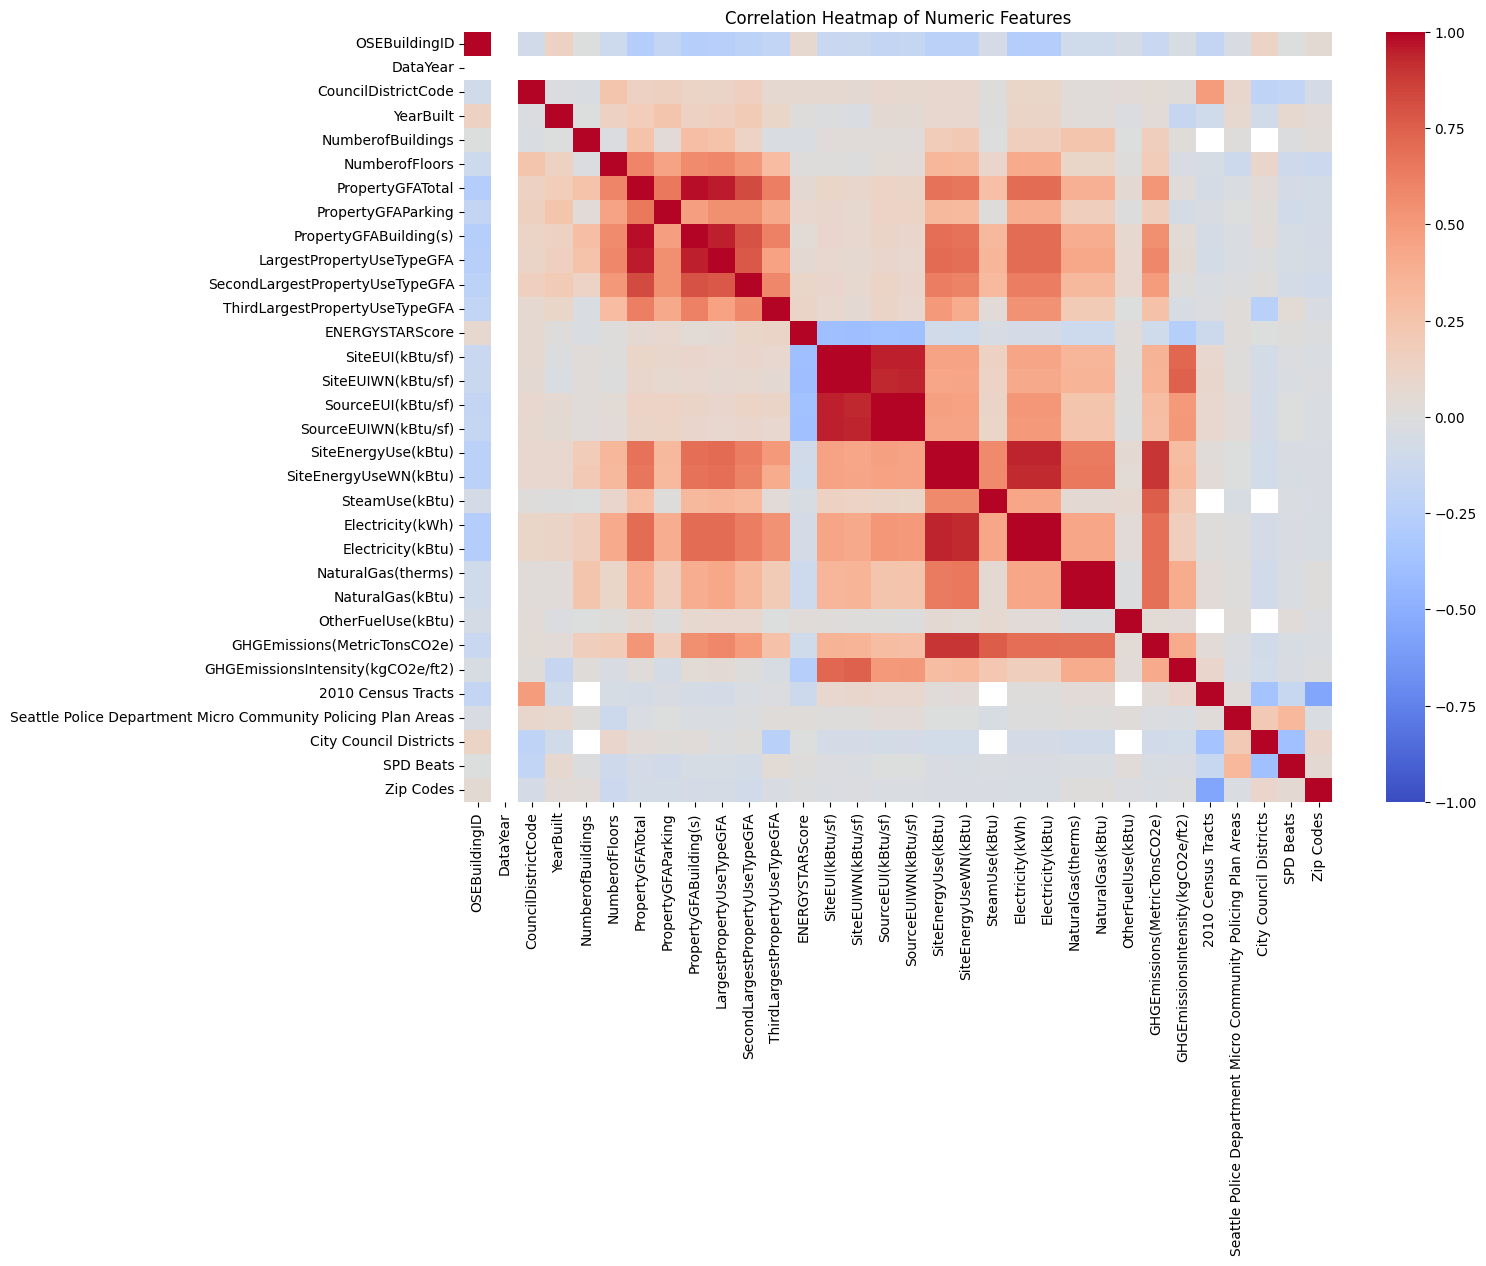

In [13]:
#4 Correlation heatmap

plt.figure(figsize=(14, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Observations**

The correlation heatmap reveals several important structural patterns in the dataset.

A first cluster composed of gross floor area–related features (PropertyGFATotal, PropertyGFABuilding(s), Largest/Second/ThirdPropertyUseTypeGFA) shows extremely high correlations (up to 0.95), indicating redundancy. These variables all describe building size, so we will simplify them to avoid multicollinearity, keeping only the most informative ones.

A second dominant cluster groups all energy consumption variables (SiteEUI, SourceEUI, SiteEnergyUse, electricity, steam, gas, GHG emissions). These features are strongly interdependent and, more importantly, many of them are derived directly from the target variable. They must therefore be excluded from the model to prevent target leakage.

We see a negative correlation between ENERGYSTARScore and energetic intensities, which is coherent : more a building is efficient, the less is its energy consumption. We can make the hypotesis that it will be a good predictor.

Overall, this analysis confirms the necessity to remove derived energy variables, reduce redundancy among GFA-related features, and preserve structural building characteristics.

**Consequences**

- Delete these columns which are derived from the target : Electricity(kWh) ;
Electricity(kBtu) ;
SteamUse(kBtu) ;
NaturalGas(therms) ;
NaturalGas(kBtu) ;
OtherFuelUse(kBtu) ;
GHGEmissions(MetricTonsCO2e) ;
GHGEmissionsIntensity(kgCO2e/ft²) ;
SiteEUI(kBtu/sf) ;
SiteEU IWN(kBtu/sf) ;
SourceEUI(kBtu/sf) ;
SourceEU IWN(kBtu/sf) ;
- Delete the redondant columns making noise : SecondLargestPropertyUseTypeGFA ;
ThirdLargestPropertyUseTypeGFA ; PropertyGFABuilding(s) ;
PropertyGFAParking


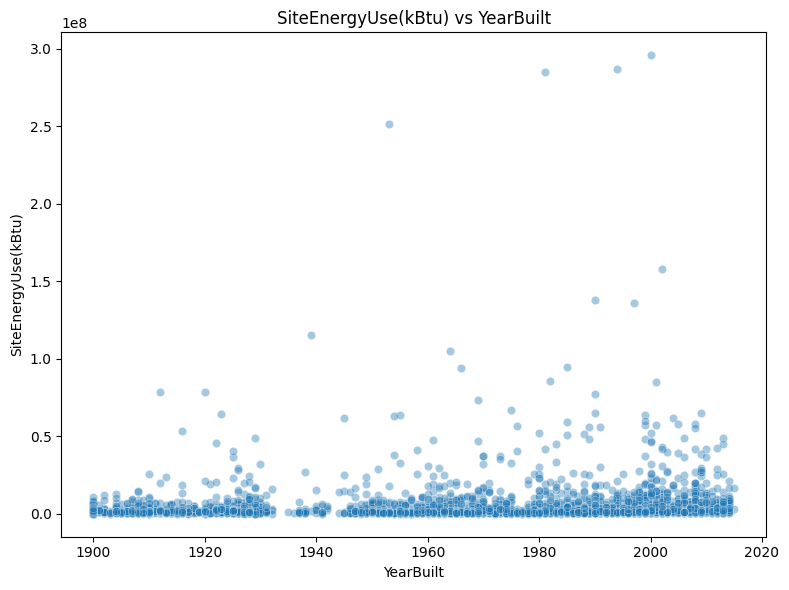

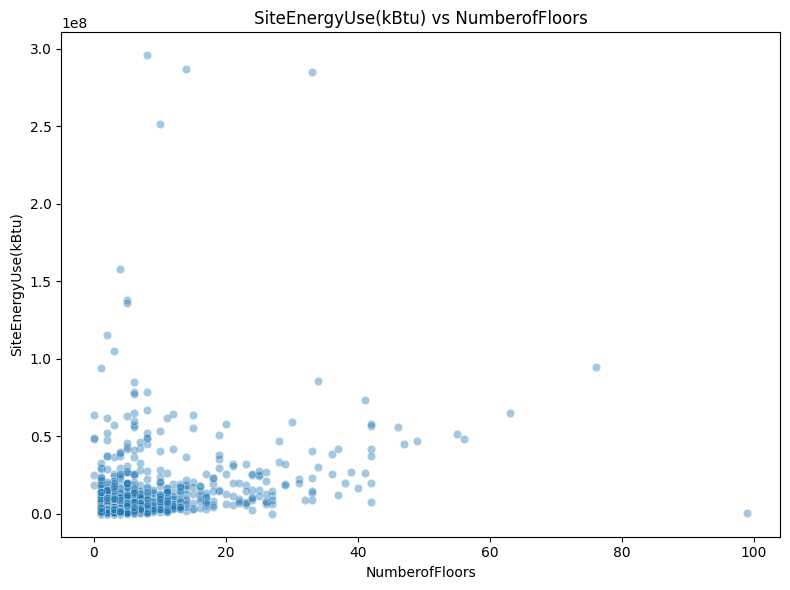

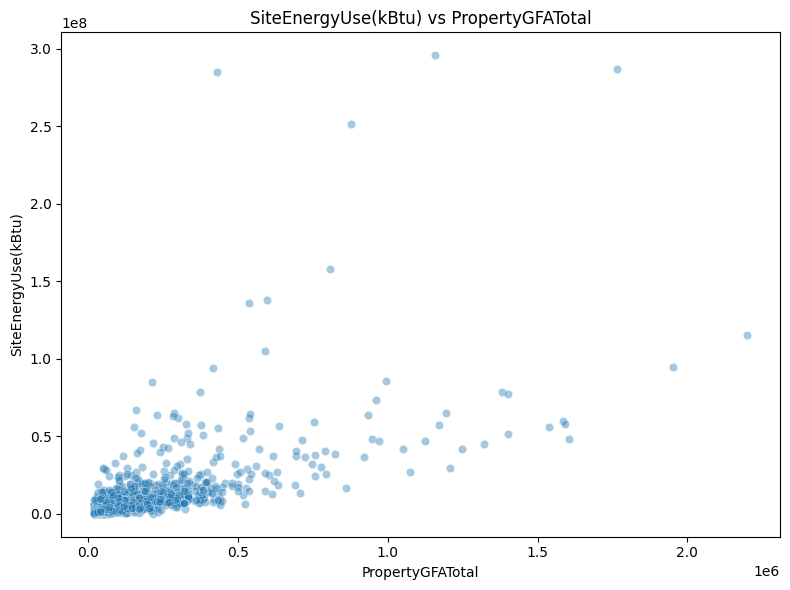

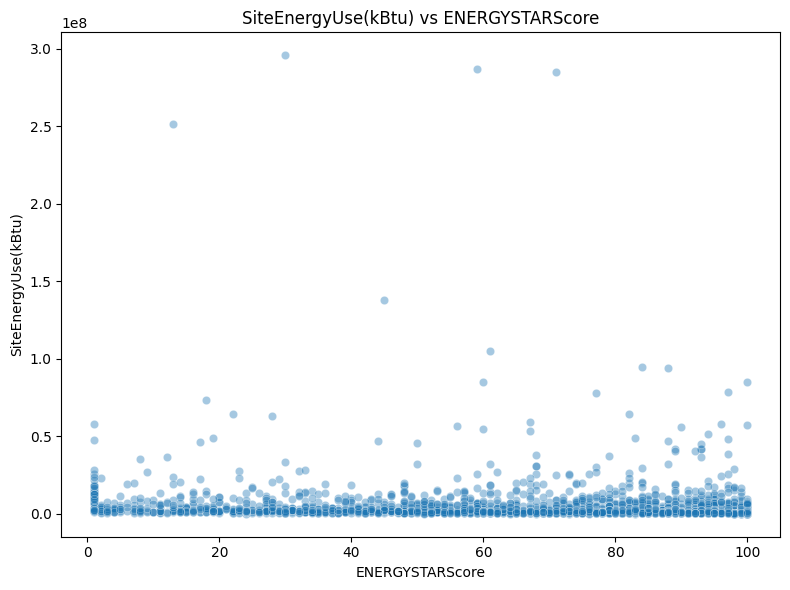

In [14]:
#5 Scatterplots vs target

for col in ["YearBuilt", "NumberofFloors", "PropertyGFATotal","ENERGYSTARScore"]:
    if col in df.columns:
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=df.sample(min(6000, len(df)), random_state=42),
                        x=col, y=target_col,
                        alpha=0.4)
        plt.title(f"{target_col} vs {col}")
        plt.tight_layout()
        plt.show()

**Observations**

Scatterplots reveal that YearBuilt and NumberofFloors have only weak relationships with total energy use: buildings of all ages and heights can exhibit both low and high consumption.

In contrast, PropertyGFATotal shows a strong and non-linear relationship with SiteEnergyUse, confirming that building size is one of the dominant predictors in the dataset.

The ENERGY STAR score presents the expected inverse correlation, but the signal is noisy due to a large number of missing or extreme values (0 and 100), which limits its predictive power.


**Consequences**

Overall, the scatterplots support the need for removing extreme outliers, and using tree-based models capable of capturing non-linear relationships.

#2 : Data Cleaning and Preprocessing

##Droping unecessary columns

In [15]:
#1 Keep only rows with valid, positive target
df = df[df[target_col].notna() & (df[target_col] > 0)]

#Keep only rows with valid, positive total floor area
if "PropertyGFATotal" in df.columns:
    df = df[df["PropertyGFATotal"].notna() & (df["PropertyGFATotal"] > 0)]

print("Shape after removing invalid target/GFA rows:", df.shape)

Shape after removing invalid target/GFA rows: (3328, 47)


In [16]:
#2 Dropping non-informative columns

id_like_cols = [
    "OSEBuildingID",
    "PropertyName",
    "TaxParcelIdentificationNumber",
    "Location",
    "DefaultData",
    "Comment",
    "2010 Census Tracts",
    "Seattle Police Department Micro Community Policing Plan Areas",
    "City Council Districts",
    "SPD Beats",
    "Zip Codes"
]

existing_id_cols = [c for c in id_like_cols if c in df.columns]
df = df.drop(columns=existing_id_cols)
print("Shape after dropping id-like columns:", df.shape)

Shape after dropping id-like columns: (3328, 36)


In [17]:
#3 : Remove the columns derived from the target (energy consumption)

df = df.drop(['Electricity(kWh)',
              'Electricity(kBtu)',
              'SteamUse(kBtu)',
              'NaturalGas(therms)',
              'NaturalGas(kBtu)',
              'OtherFuelUse(kBtu)',
              'GHGEmissions(MetricTonsCO2e)',
              'GHGEmissionsIntensity(kgCO2e/ft2)',
              'SiteEUI(kBtu/sf)',
              'SiteEUIWN(kBtu/sf)',
              'SourceEUI(kBtu/sf)',
              'SourceEUIWN(kBtu/sf)',
              'SiteEnergyUseWN(kBtu)'], axis=1)

print("Shape after leakage drop:", df.shape)

Shape after leakage drop: (3328, 23)


In [18]:
#4 Remove redundant area-related variables

redundant_cols = [
    "PropertyGFABuilding(s)",
    "PropertyGFAParking",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA"
]

redundant_cols = [c for c in redundant_cols if c in df.columns]
df = df.drop(columns=redundant_cols)

# Remove derived EUI column if created in the EDA
if "EUI" in df.columns:
    df = df.drop(columns=["EUI"])

print("Dropped redundant area/EUI columns:", redundant_cols)
print("Shape after redundancy drop:", df.shape)

Dropped redundant area/EUI columns: ['PropertyGFABuilding(s)', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
Shape after redundancy drop: (3328, 19)


In [19]:
#5 Convert important categorical variables to 'object'

if "BuildingType" in df.columns:
    df["BuildingType"] = df["BuildingType"].astype(str)

if "CouncilDistrictCode" in df.columns:
    df["CouncilDistrictCode"] = df["CouncilDistrictCode"].astype(str)

##Preprocessing

In [20]:
#1 Feature engineering

# Building age
if "YearBuilt" in df.columns:
    df["BuildingAge"] = 2015 - df["YearBuilt"]

# Log transforms of skewed numeric features
df["log_PropertyGFATotal"] = np.log1p(df["PropertyGFATotal"])
df["log_LargestPropertyUseTypeGFA"] = np.log1p(df["LargestPropertyUseTypeGFA"])

# ENERGYSTARScore: treat 0 as missing (common anomaly)
if "ENERGYSTARScore" in df.columns:
    df.loc[df["ENERGYSTARScore"] == 0, "ENERGYSTARScore"] = np.nan

#df["GFA_per_floor"] = df["PropertyGFATotal"] / df["NumberofFloors"].replace(0, np.nan)
#df["GFA_ratio"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"].replace(0, np.nan)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(df.shape)

(3328, 22)


In [21]:
#2 X/y Split

target_col="SiteEnergyUse(kBtu)"
X = df.drop(columns=[target_col])
y = np.log1p(df[target_col])
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("X shape:", X.shape)

X shape: (3328, 21)


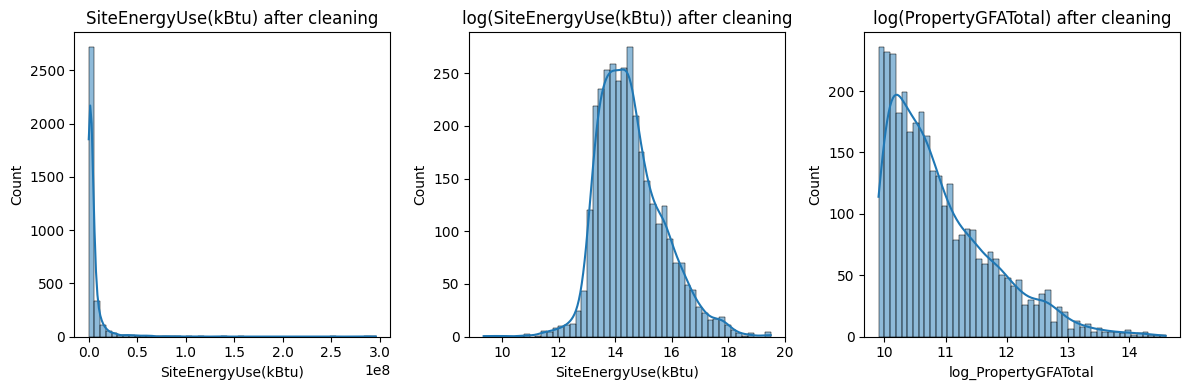

In [22]:
# Distribution checks after cleaning

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.histplot(df[target_col], bins=50, kde=True)
plt.title("SiteEnergyUse(kBtu) after cleaning")

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(df[target_col]), bins=50, kde=True)
plt.title("log(SiteEnergyUse(kBtu)) after cleaning")

plt.subplot(1, 3, 3)
sns.histplot(df["log_PropertyGFATotal"], bins=50, kde=True)
plt.title("log(PropertyGFATotal) after cleaning")

plt.tight_layout()
plt.show()

After cleaning, the distribution of the raw target remains highly skewed, whereas the log-transformed target is much closer to a symmetric, bell-shaped distribution. The same effect is observed for the log of the total floor area.

In [23]:
#2 Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (2662, 21)
Test size: (666, 21)


In [26]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [34]:
#3
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder

# Numeric preprocessing : median if null + scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing : "Missing" if null + enconding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

categorical_transformer2 = Pipeline(steps=[
    ('catboost', CatBoostEncoder())
])

# Full preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer2, categorical_cols)
    ]
)

print("Preprocessor ready.")

Preprocessor ready.


# 4 : Modeling

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test, name="model"):
    """
    Evaluate a model trained on log-transformed target.
    """
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)        # inverse log1p
    y_true = np.expm1(y_test)            # back to original scale

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"MAE  : {mae:,.2f}")
    print(f"RMSE : {rmse:,.2f}")
    print(f"R²   : {r2:.4f}")

    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

## A : Linear regression

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

linreg_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

linreg_model.fit(X_train, y_train)

linreg_results = evaluate_model(linreg_model, X_test, y_test, name="Linear Regression")


=== Linear Regression ===
MAE  : 1,721,376.17
RMSE : 7,245,840.56
R²   : 0.2503
MAPE      : 73.71%
sMAPE     : 33.33%
RMSLE     : 0.5716
MAE_norm  : 0.9722 (relative to median target)


**Interpretation**

The linear regression model performs extremely poorly, confirming that
the relationship between building characteristics and energy consumption is
highly non-linear.

The large MAE and RMSE values reflect the wide variance of
energy use across the dataset, especially due to very large buildings.

This
baseline shows that linear models are unable to capture the structural patterns
observed in the exploratory analysis, and that non-linear tree-based models are
required.


## B :  Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

rf_results = evaluate_model(rf_model, X_test, y_test, name="Random Forest")


=== Random Forest ===
MAE  : 1,495,107.08
RMSE : 4,017,257.97
R²   : 0.7695
MAPE      : 53.91%
sMAPE     : 30.37%
RMSLE     : 0.5214
MAE_norm  : 0.8444 (relative to median target)


The Random Forest model achieves a good performance, showing a
big improvement over the linear regression baseline. This confirms that
energy consumption depends on highly non-linear interactions between building
characteristics, which tree-based models are well suited to capture.

The MAE
and RMSE values are pretty low relative to the scale of the target, showing that
the model generalizes well across different building types and sizes.

##B : ExtraTrees Regressor


In [42]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline

et_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", ExtraTreesRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

et_model.fit(X_train, y_train)

et_results = evaluate_model(et_model, X_test, y_test, name="ExtraTrees")


=== ExtraTrees ===
MAE  : 1,378,327.53
RMSE : 3,633,659.10
R²   : 0.8115
MAPE      : 54.77%
sMAPE     : 30.58%
RMSLE     : 0.5226
MAE_norm  : 0.7785 (relative to median target)


##C : Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = Pipeline(steps=[
    ("preprocessing", preprocessor2),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

gbr_params = {
    "regressor__n_estimators": [200, 300],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [2, 3]
}

gbr_grid = GridSearchCV(
    gbr_model,
    gbr_params,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)

print("Best GBR Params:", gbr_grid.best_params_)

gbr_results = evaluate_model(
    gbr_grid.best_estimator_,
    X_test,
    y_test,
    name="Gradient Boosting"
)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best GBR Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 2, 'regressor__n_estimators': 300}

=== Gradient Boosting ===
MAE  : 1,508,937.32
RMSE : 4,395,639.56
R²   : 0.7241


##D : LightGBM Regressor

In [ ]:
try:
    import lightgbm as lgb

    lgb_model = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("regressor", lgb.LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=50,
            random_state=42
        ))
    ])

    lgb_model.fit(X_train, y_train)
    lgb_results = evaluate_model(lgb_model, X_test, y_test, name="LightGBM")

except Exception as e:
    print("LightGBM not available:", e)
    lgb_results = None

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 98
[LightGBM] [Info] Start training from score 14.559103

=== LightGBM ===
MAE  : 1,558,303.95
RMSE : 4,417,498.13
R²   : 0.7213


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


##E :  XGBoost

In [ ]:
try:
    from xgboost import XGBRegressor

    xgb_model = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_model.fit(X_train, y_train)

    xgb_results = evaluate_model(xgb_model, X_test, y_test, name="XGBoost")

except Exception as e:
    print("XGBoost not installed:", e)
    xgb_results = None


=== XGBoost ===
MAE  : 1,612,074.96
RMSE : 6,907,351.37
R²   : 0.3187


##F : CastBoostRegressor

In [ ]:
try:
    from catboost import CatBoostRegressor

    cbr_model = Pipeline(steps=[
        ("preprocessing", preprocessor2),
        ("regressor", CatBoostRegressor(
            loss_function="RMSE",
            depth=6,
            learning_rate=0.05,
            n_estimators=500,
            random_state=42,
            verbose=False
        ))
    ])

    cbr_model.fit(X_train, y_train)
    cbr_results = evaluate_model(cbr_model, X_test, y_test, name="CatBoost Regressor")

except Exception as e:
    print("CatBoost not available:", e)
    cbr_results = None



=== CatBoost Regressor ===
MAE  : 1,491,473.11
RMSE : 4,412,150.02
R²   : 0.7220


## G : Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", DecisionTreeRegressor(
        max_depth=None,      # fully grown tree
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ))
])

dt_model.fit(X_train, y_train)

dt_results = evaluate_model(dt_model, X_test, y_test, name="Decision Tree")


=== Decision Tree ===
MAE  : 2,189,866.89
RMSE : 5,571,308.30
R²   : 0.5568


#8 : Comparison of models

In [47]:
results_df = pd.DataFrame([
    linreg_results,
    rf_results,
    et_results,
    gbr_results,
    lgb_results,
    xgb_results,
    cbr_results,
    dt_results
])

# Tri par R² décroissant (meilleur en premier)
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)

results_df


,Model,MAE,RMSE,R2
0,ExtraTrees,1.378328e+06,3.633659e+06,0.811456
1,Random Forest,1.495107e+06,4.017258e+06,0.769546
2,Linear Regression,1.721376e+06,7.245841e+06,0.250273


Although the absolute error metrics (MAE and RMSE) appear large in magnitude, this outcome is inherent to the structure of the dataset rather than indicative of inadequate model performance. The target variable exhibits a heavy-tailed distribution, with energy consumption ranging from under one million kBtu for small buildings to over seventy million kBtu for large institutional facilities. In such contexts, absolute errors inevitably scale with the magnitude of the observations, producing large numerical values even for well-fitted models.

Moreover, MAE and RMSE are highly sensitive to extreme values, and a small subset of very high-consumption buildings disproportionately influences these metrics. Despite this, the models achieve strong explanatory power as reflected by their R² scores, and the residual analysis confirms that predictive errors are centered and structurally consistent across the majority of the dataset.

Consequently, these metrics remain coherent with the statistical properties of the data, and the overall performance of the tree-based models can be considered robust given the intrinsic complexity of the prediction task.

#9 : Tuning of best models

## ExtraTrees Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# ExtraTrees pipeline
et_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", ExtraTreesRegressor(random_state=42, n_jobs=-1))
])

et_params = {
    "regressor__n_estimators": [300, 500, 800, 1200],
    "regressor__max_depth": [None, 20, 30, 40],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2", None]
}

et_search = RandomizedSearchCV(
    et_pipe,
    param_distributions=et_params,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

et_search.fit(X_train, y_train)

print("Best ExtraTrees parameters:")
print(et_search.best_params_)

et_tuned = et_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best ExtraTrees parameters:
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 20}


In [ ]:
et_tuned = et_search.best_estimator_
et_tuned_results = evaluate_model(et_tuned, X_test, y_test, name="ExtraTree Tuned")


=== ExtraTree Tuned ===
MAE  : 1,387,780.01
RMSE : 3,636,741.36
R²   : 0.8111


##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

# Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Hyperparameter search space
rf_params = {
    "regressor__n_estimators": [300, 500, 800, 1200],
    "regressor__max_depth": [None, 15, 25, 35, 50],
    "regressor__min_samples_split": [2, 5, 10, 20],
    "regressor__min_samples_leaf": [1, 2, 4, 8],
    "regressor__max_features": ["sqrt", "log2", None],
    "regressor__bootstrap": [True, False]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_params,
    n_iter=20,                    # reasonable search budget
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Run optimization
rf_search.fit(X_train, y_train)

print("Best Random Forest parameters:")
print(rf_search.best_params_)

# Retrieve tuned model
rf_tuned = rf_search.best_estimator_

# Evaluate
rf_tuned_results = evaluate_model(rf_tuned, X_test, y_test, name="Random Forest Tuned")
rf_tuned_results


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest parameters:
{'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 25, 'regressor__bootstrap': True}

=== Random Forest Tuned ===
MAE  : 1,501,281.12
RMSE : 4,043,595.88
R²   : 0.7665


{'Model': 'Random Forest Tuned',
 'MAE': 1501281.1245415485,
 'RMSE': np.float64(4043595.8808287536),
 'R2': 0.7665139283532117}

##C : LightGBM Regressor

In [ ]:
from lightgbm import LGBMRegressor

lgb_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", LGBMRegressor(random_state=42))
])

lgb_params = {
    "regressor__n_estimators": [300, 600, 1000],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__num_leaves": [31, 50, 70],
    "regressor__max_depth": [-1, 10, 20],
    "regressor__feature_fraction": [0.8, 1.0],
    "regressor__bagging_fraction": [0.7, 0.8, 1.0],
    "regressor__bagging_freq": [0, 1]
}

lgb_search = RandomizedSearchCV(
    lgb_pipe,
    param_distributions=lgb_params,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

lgb_search.fit(X_train, y_train)

print("Best LightGBM parameters:")
print(lgb_search.best_params_)

lgb_tuned = lgb_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

In [ ]:
lgb_tuned = lgb_search.best_estimator_
lgb_tuned_results = evaluate_model(lgb_tuned, X_test, y_test, name="LightGBMBoost Tuned")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

=== XGBoost Tuned ===
MAE  : 1,502,937.05
RMSE : 4,434,256.74
R²   : 0.7192


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


##Final comparison

In [ ]:
results_df = pd.DataFrame([
    linreg_results,
    rf_results,
    rf_tuned_results,
    et_results,
    et_tuned_results,
    gbr_results,
    lgb_results,
    lgb_tuned_results,
    xgb_results,
    cbr_results,
    dt_results
])

# Tri par R² décroissant (meilleur en premier)
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)

results_df


,Model,MAE,RMSE,R2
0,ExtraTrees,1.378328e+06,3.633659e+06,0.811456
1,ExtraTree Tuned,1.387780e+06,3.636741e+06,0.811136
2,Random Forest,1.495107e+06,4.017258e+06,0.769546
3,Random Forest Tuned,1.501281e+06,4.043596e+06,0.766514
4,Gradient Boosting,1.508937e+06,4.395640e+06,0.724089
5,CatBoost Regressor,1.491473e+06,4.412150e+06,0.722012
6,LightGBM,1.558304e+06,4.417498e+06,0.721338
7,XGBoost Tuned,1.502937e+06,4.434257e+06,0.719219
8,Decision Tree,2.189867e+06,5.571308e+06,0.556759
9,XGBoost,1.612075e+06,6.907351e+06,0.318684


#10 : Feature importance and residual analysis

In [ ]:
# Retrieve the fitted ExtraTrees model (non tuned)
et_reg = et_model.named_steps["regressor"]

# Retrieve the preprocessing pipeline
preproc = et_model.named_steps["preprocessing"]

# Extract OneHotEncoder fitted on categorical columns
ohe = preproc.named_transformers_["cat"].named_steps["onehot"]

# Get the names of the encoded categorical features
ohe_features = ohe.get_feature_names_out(categorical_cols)

# Final feature list = numeric columns + onehot-encoded categorical columns
all_features = numeric_cols + list(ohe_features)

# Sanity check
print("Nb features sent to model:", len(all_features))
print("Nb importances from model:", len(et_reg.feature_importances_))

# Build DataFrame
feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": et_reg.feature_importances_
}).sort_values("Importance", ascending=False).reset_index(drop=True)

feat_imp_df.head(20)


Nb features sent to model: 632
Nb importances from model: 632


,Feature,Importance
0,log_PropertyGFATotal,0.325140
1,log_LargestPropertyUseTypeGFA,0.139470
2,PropertyGFATotal,0.107885
3,LargestPropertyUseTypeGFA,0.064665
4,ENERGYSTARScore,0.040138
5,PrimaryPropertyType_Low-Rise Multifamily,0.034215
6,PrimaryPropertyType_Supermarket/Grocery Store,0.017181
7,BuildingAge,0.011890
8,YearBuilt,0.011885
9,LargestPropertyUseType_Multifamily Housing,0.010891


**Interpretation**

The ExtraTrees model identifies building size as the primary driver of total energy consumption.
Log-transformed surface metrics, together with direct floor-area variables, represent more than half of the total feature importance, confirming the central role of building scale in determining energy use.

Building usage is the second most influential factor. High-consumption categories such as supermarkets and lower-consumption categories such as non-refrigerated warehouses contribute to a clear differentiation in energy profiles.

Efficiency indicators, particularly the ENERGY STAR Score, along with building age, provide additional but more moderate explanatory power. These variables help refine predictions by accounting for differences in operational efficiency and construction standards.

Overall, the model shows that total energy consumption is primarily shaped by building size, functional use, and efficiency level, while structural and categorical characteristics provide complementary information that improves prediction accuracy

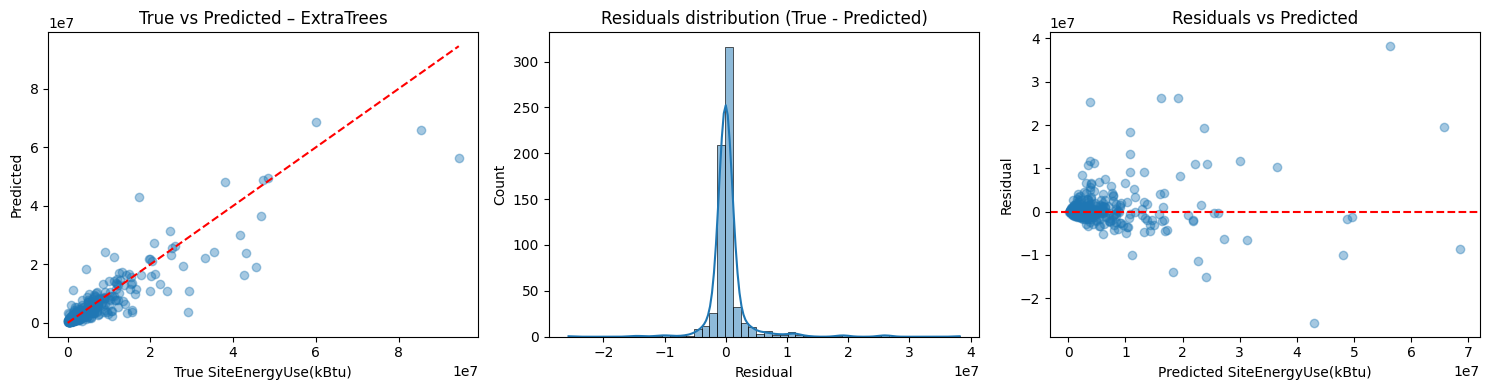

In [ ]:
# Residual analysis

final_model = et_model  # or et_tuned if you choose the tuned version

# Predictions on the test set (back to original scale)
y_test_true = np.expm1(y_test)
y_test_pred = np.expm1(final_model.predict(X_test))

residuals = y_test_true - y_test_pred

plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
plt.scatter(y_test_true, y_test_pred, alpha=0.4)
plt.xlabel("True SiteEnergyUse(kBtu)")
plt.ylabel("Predicted")
plt.title("True vs Predicted – ExtraTrees")
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], "r--")

plt.subplot(1, 3, 2)
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals distribution (True - Predicted)")
plt.xlabel("Residual")

plt.subplot(1, 3, 3)
plt.scatter(y_test_pred, residuals, alpha=0.4)
plt.xlabel("Predicted SiteEnergyUse(kBtu)")
plt.ylabel("Residual")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted")

plt.tight_layout()
plt.show()

**Interpretation**

1.True vs Predicted Values

The predicted energy consumption follows the general diagonal trend, indicating that the model captures the main structure of the data. However, a systematic underestimation appears for buildings with extremely high energy use (above approximately 4–5×10⁷ kBtu). These cases correspond to a very small portion of the dataset and exhibit substantial variability, which makes them inherently difficult to model. This behavior is expected in domains with heavy-tailed targets.

2.Distribution of Residuals

Residuals are globally centered around zero, indicating that the model is not biased on average. The distribution shows a sharp peak near zero, consistent with the strong performance reported in the evaluation metrics. A right-skewed tail is visible, reflecting occasional underestimation of the largest consumers. This is aligned with the observations from the true vs predicted plot and reinforces the idea that extreme buildings dominate the remaining prediction errors.

3.Residuals vs Predicted Values

For the majority of buildings, residuals are well distributed around zero with relatively constant variance. As predicted values increase, residual variance becomes larger, forming a slight funnel shape. This pattern is typical for datasets where the target spans several orders of magnitude, and it justifies the use of a logarithmic transformation of the target variable. The absence of strong structural patterns in the residual cloud confirms that the model does not overlook key explanatory relationships.

4.Overall Interpretation

The residual analysis supports the conclusion that the ExtraTrees model performs well across most of the dataset, with stable and unbiased predictions. The remaining prediction errors are primarily concentrated among extreme high-energy buildings, which represent rare and highly variable cases. Despite this, the model remains robust and generalizes effectively, validating the modeling approach and preprocessing strategy used.

#11 : Conclusion


This notebook implemented a complete machine learning workflow to model building energy consumption using the Seattle 2015 benchmarking dataset. After an exploratory analysis, the dataset was cleaned by removing non-informative and target-leaking variables, addressing missing values, applying log-transformations to skewed numerical features, and encoding categorical variables. Several models were evaluated, including linear regression, Random Forest, Gradient Boosting, LightGBM, XGBoost, CatBoost, and ExtraTrees.

Tree-based ensemble models consistently outperformed linear approaches, confirming the strong non-linearity and heterogeneity of the dataset. ExtraTrees delivered the most stable performance, with the highest R² score (≈ 0.81). Feature importance analysis showed that building size is the dominant predictor of total energy use, followed by building type, efficiency indicators, and basic structural characteristics.

Despite these strengths, the model’s R² remains constrained by several limitations of the dataset. Energy consumption spans more than two orders of magnitude, creating a heavy-tailed distribution that inherently limits predictive accuracy. The dataset also contains heterogeneous building categories, missing operational variables, and extreme outliers that disproportionately influence absolute errors and restrict the achievable R². As a result, we couldn't pass 0,81 of R² despite using different feature ingeniering, models and hyperparameters.

Overall, the final ExtraTrees model provides a robust and interpretable framework that captures the main drivers of energy consumption while highlighting the structural limitations of the available data. These results offer a solid foundation for future improvements such as segmented modeling, integration of operational features, or temporal extensions.